# Abstract


이번 AI 프로젝트에서는 실내 장애물과 오차가 발생하는 환경에서 각 위치 측정 센서별 Time Difference Of Arrival(도달 시간 차이)을 통해 정확한 타겟 위치를 예측하는 딥 러닝 모델을 제안합니다. 저희가 구상한 딥러닝 모델은 다음과 같은 순서로 진행됩니다. 각 센서별 TDOA 측정값에 내부 장애물로 인해 발생할 수 있는 에러를 반영해 줍니다. 에러가 반영된 TDOA 데이터는 TDOA 이미지로 변환을 합니다. TDOA 이미지는 각 이미지 그리드에서 쌍곡선 그래프가 지나갈 확률로 이루어져 있습니다. TDOA 이미지를 입력 데이터로 축적하고 처리하여 역전파를 통해 목표 위치를 추정하기 위해 완전 연결 계층이 있는 CNN 모델을 학습합니다. 시뮬레이션 결과는 우리가 제안한 TITT 모델이 많은 클러터가 있는 도전적인 환경에서 단순한 딥 러닝 모델보다 성능이 우수함을 보여줍니다.



# Introduction 


With the development of IT technology, unmanned systems are gradually being promoted in many fields. In particular, in unmanned stores such as Amazon Go, when a customer puts items in a shopping cart and goes straight to the exit without a checkout process, the product that purchased are identified and automatic payment is made. This technology is possible because many sensors and cameras in the store can be used to determine what products a customer has in their shopping cart.
  
However, these sensors and cameras are expensive to purchase and for operate. In order to reduce cost, many technologies have been studied for accurately locating the target even in a narrow room but there are many obstacles.
Recent preliminary studies have tried to obtain accurate TDOA (difference in signal propagation time of different transmitters (also called tags) measured at receivers (anchors)) through several algorithms, especially deep learning. 

 However, this method simply inferred the correct TDOA value and tracked the location using the hyperbolic equation, and did not use deep learning for the entire process. In addition, the method of estimating the position through TDOA is essential to find the intersection of the hyperbolic equations, but this process needs a lot of computer resources to solve these complex nonlinear equations.
Therefore, to solve these problems, we will build a deep lear:ning model that estimates the exact coordinates of the target by using the TDOA values extracted from the rough space. In particular, we will build a CNN model by converting each TDOA measurement into a TDOA image. We expect that it will be possible to accurately and quickly determine the location of the target even in complex spaces such as unmanned convenience stores and indoor gyms.



# Our codes

## Implement packages

In [ ]:
import os
import os.path as osp

import numpy as np

import random
import csv

import pandas as pd
import matplotlib.pyplot as plot
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
import random

import tensorflow as tf
import tensorflow.keras as keras

## Hyperparameters -- 하이퍼파라미터 세팅 과정 서술..???
+ grid_size, probability_gap 설명

In [ ]:
######################################################
# fix me
# Parameters for CNNs
CNN1_inputchannel = 3
CNN1_outchannel = 128 
CNN1_kernal = 2
CNN1_stride = 1

CNN2_outchannel = 256
CNN2_kernal = 2
CNN2_stride = 1

CNN3_outchannel = 256
CNN3_kernal = 2
CNN3_stride = 1

Pool_kernal = 2 # max pooling
Pool_stride = 2

num_epochs = 10
batch_size = 10

sensor_ref = [0,0]
sensor1 = [25,0]
sensor2 = [0,25]
sensor3 = [25,25]

world_size_x = 25
world_size_y = 25
grid_size = 0.25

epsilon = 0.01
probability_gap = 10
######################################################

# Overall procsees for creating train dataset

1. Create arbitraely X and Y target data between 0~25
    + Target data is made!
2. Apply random noise to arbitraely generated target data (hat data)
    + this is hat data that measured by device
    + X target data with noise is X_hat, Y target data with noise is Y_hat
3. Create distance between each sensor and hat data

4. Apply environmental error

5. Create TDOA between reference sensor and each sensor

6. Scaling for data

7. Create TDOA Image from TDOA data

### Create arbitraely X and Y target data between 0~25

In [ ]:
MC_N = 10**4   # Number of total simulation
MC_N = int(MC_N * 2)

size_x = 25   # X axis size
size_y = 25   # Y axis size

X_x_list = np.random.rand(MC_N,1) * size_x    # Target X axis data that generated randomly between 0~25
X_x_list = X_x_list.flatten().tolist()
X_y_list = np.random.rand(MC_N,1) * size_y    # Target Y axis data that generated randomly between 0~25
X_y_list = X_y_list.flatten().tolist()

sensor_ref_x_list = [0] * MC_N                      #sensor ref x coordinate
sensor_ref_y_list = [0] * MC_N                      #sensor ref  y coordinate
sensor_one_x_list = [size_x] * MC_N                 #sensor 1 x coordinate
sensor_one_y_list = [0] * MC_N                      #sensor 1 y coordinate
sensor_two_x_list = [0] * MC_N                      #sensor 2 x coordinate
sensor_two_y_list = [size_y] * MC_N                 #sensor 2 y coordinate
sensor_three_x_list = [size_x] * MC_N                #sensor 3 x coordinate
sensor_three_y_list = [size_y] * MC_N                #sensor 3 y coordinate

### Apply random noise to arbitraely generated target data (hat data)

+ 사진사진사진사진사진사진사진사진사진사진사진사진사진사진사진
 
 - 에러가 어떤 근거로 설정되었는지 설명추가
 - 실제로 측정된 데이터는 있지만, 양이 부족해서(?) 학습시키기엔 부족했다
 - 그래서 실험에 사용된 태그의 스펙을 이용하여 오차범위를 알아낸뒤 시뮬레이션을 위해 실제 측정값과 비슷하게 스펙 오차범위를 랜덤하게 적용시켰다.

In [ ]:

max_device_error = 0.1  #위의 사진에 의해 device 기기의 에러값 선언

noise_x_list = []
noise_y_list = []


while(len(noise_x_list) != MC_N):
    #After generating a Gaussian standard normal distribution random number from mean 0 stdv 1,
    # multiplicate with max_device_error and scaled to the maximum error.
    temp_x = np.random.randn()  * max_device_error   
    temp_y = np.random.randn()  * max_device_error
    
    if( (temp_x**2 + temp_y**2 < max_device_error ** 2) ):    
        noise_x_list.append(temp_x)
        noise_y_list.append(temp_y)
    
    
X_hat_x_list = [x+y for x,y in zip(X_x_list, noise_x_list)]   # X coordinate generated from device
X_hat_y_list = [x+y for x,y in zip(X_y_list, noise_y_list)]   # Y coordinate generated from device

### Create distance between each sensor and hat data

In [ ]:
distance_ref_X_hat_list = [-100] * MC_N  
distance_one_X_hat_list = [-100] * MC_N  
distance_two_X_hat_list = [-100] * MC_N  
distance_three_X_hat_list = [-100] * MC_N  


for i in range(MC_N):
    X_x = X_x_list[i]
    X_y = X_y_list[i]
    
    X_hat_x = X_hat_x_list[i]
    X_hat_y = X_hat_y_list[i]
    
    sensor_ref_x = sensor_ref_x_list[i]
    sensor_ref_y = sensor_ref_y_list[i]
    sensor_one_x = sensor_one_x_list[i]
    sensor_one_y = sensor_one_y_list[i]
    sensor_two_x = sensor_two_x_list[i]
    sensor_two_y = sensor_two_y_list[i]
    sensor_three_x = sensor_three_x_list[i]
    sensor_three_y = sensor_three_y_list[i]
    
    
    distance_ref_X_hat_list[i] = math.sqrt((X_hat_x - sensor_ref_x)**2 + (X_hat_y - sensor_ref_y)**2)  # ref과 Xhat 거리
    distance_one_X_hat_list[i] = math.sqrt((X_hat_x - sensor_one_x)**2 + (X_hat_y - sensor_one_y)**2)  # 1과 Xhat 거리
    distance_two_X_hat_list[i] = math.sqrt((X_hat_x - sensor_two_x)**2 + (X_hat_y - sensor_two_y)**2)  # 2와 Xhat 거리
    distance_three_X_hat_list[i] = math.sqrt((X_hat_x - sensor_three_x)**2 + (X_hat_y - sensor_three_y)**2)  # 3과 타Xhat 거리


### Apply environmental error

-프레넬 설명과 그림


In [ ]:
df = pd.DataFrame(data = {'X_x':X_x_list , 'X_y' : X_y_list , 
                         'X_noise_x':noise_x_list , 'X_noise_y' : noise_y_list , 
                          'X_hat_x':X_hat_x_list ,'X_hat_y':X_hat_y_list,
                          'distance_ref_X_hat' : distance_ref_X_hat_list , 'distance_one_X_hat' : distance_one_X_hat_list,
                          'distance_two_X_hat' : distance_two_X_hat_list , 'distance_three_X_hat' : distance_three_X_hat_list   
                         })


def create_environment_error(distance):
    error_rate = 0.3
    if(float(np.random.rand()) < error_rate):
        obstacle_heigth =  3 * np.random.rand()   #부딪히는 물체의 길이
        if(distance < obstacle_heigth):         # 말이 안되는거 그냥 0으로 채워 넣음
            return 0
        
        #By 프레넬 영역을 이용한 추가 이동 거리 구현(함 위에 사이트 읽어보고 이상하다 싶으면 바로 말해줘요)
        distance1 = np.random.randn() + (distance/2)
        distance2 = distance - distance1
        if(distance1 < 0 or distance2 < 0):     # 말이 안되는거 그냥 0으로 채워 넣음
            return 0 
        
        Fresnel_a = 0.01 * math.sqrt(distance1 * distance2 / (distance1+distance2))

        break_n = 1
        while(Fresnel_a < obstacle_heigth):
            Fresnel_a = Fresnel_a * (break_n+1) / break_n
            break_n +=1
        
        distance_final = math.sqrt(np.square(distance1) + np.square(Fresnel_a)) + math.sqrt(np.square(distance2) + np.square(Fresnel_a))
        
        # 너무 이상한값 우리선에서 정리
        if(distance_final > 50 ):
            distance_final = 100
        
    else:
        distance_final = distance

    return distance_final

df['error_distance_ref_X_hat'] = df['distance_ref_X_hat'].apply(create_environment_error)
df['error_distance_one_X_hat'] = df['distance_one_X_hat'].apply(create_environment_error)
df['error_distance_two_X_hat'] = df['distance_two_X_hat'].apply(create_environment_error)
df['error_distance_three_X_hat'] = df['distance_three_X_hat'].apply(create_environment_error)


### Create TDOA between reference sensor and each sensor

In [ ]:
df['TDOA_X_hat_ref_one_error'] = df['error_distance_ref_X_hat'] - df['error_distance_one_X_hat']
df['TDOA_X_hat_ref_two_error'] = df['error_distance_ref_X_hat'] - df['error_distance_two_X_hat']
df['TDOA_X_hat_ref_three_error'] = df['error_distance_ref_X_hat'] - df['error_distance_three_X_hat']

df_parsing = df[['TDOA_X_hat_ref_one_error' , 'TDOA_X_hat_ref_two_error' , 'TDOA_X_hat_ref_three_error' , 'X_x' , 'X_y']]
df_parsing.columns = ['TDOA_1', 'TDOA_2', 'TDOA_3' , 'coordinate_x' , 'coordinate_y']

df_parsing = df_parsing.reset_index(drop=True)

TDOA_X_ref_one_list = df_parsing['TDOA_1'].tolist()
TDOA_X_ref_two_list = df_parsing['TDOA_2'].tolist()
TDOA_X_ref_three_list = df_parsing['TDOA_3'].tolist()

TDOA_pair_ref = [(TDOA_X_ref_one_list[ii], TDOA_X_ref_two_list[ii], TDOA_X_ref_three_list[ii]) for ii in range(len(TDOA_X_ref_one_list))]

ylabel_ref = [(X_x_list[ii] / size_x, X_y_list[ii] / size_y ) for ii in range(len(X_x_list))] 

### Scaling for data  -- <이해못함>

In [ ]:
def ScalerCoordinate(value):   #world size = area's width and height , value =  x,y coordinate
    world_size = 25
    value = value / world_size
    return value


def ScalerTDOA(value):   #world size = area's width and height , value = TDOA value
    world_size = 25 * 2**(0.5)
    world_size = 100
    value = value / world_size
    return value


df = df_parsing

df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']] = df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].apply(ScalerTDOA)  #길이에 대하여 스케일링
df[['coordinate_x' , 'coordinate_y']] = df[['coordinate_x' , 'coordinate_y']].apply(ScalerCoordinate)  #좌표에 대하여 스케일링

train_df , test_df = train_test_split(df, test_size = 0.2)

train_TDOAs = train_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
train_X_Hats = train_df[['coordinate_x' , 'coordinate_y']].to_numpy()

test_TDOAs = test_df[['TDOA_1' , 'TDOA_2' , 'TDOA_3']].to_numpy()
test_X_Hats = test_df[['coordinate_x' , 'coordinate_y']].to_numpy()

### Create TDOA Image from TDOA data

In [ ]:
# TDOA image 생성 모듈 정의
# input: TDPA
# output: TDOA_images
  
def TDOA_image_generation(sensor1, sensor2, TDOA, world_size_x, world_size_y, grid_size, epsilon, probability_gap):
   
  center_x = np.linspace(0 , world_size_x , int(world_size_x / grid_size))  + 0.5*grid_size
  center_y = np.linspace(world_size_y , 0 , int(world_size_x / grid_size))  + 0.5*grid_size
  cord_center_x, cord_center_y = np.meshgrid(center_x,center_y)
  
  distance_matrix = np.sqrt((cord_center_x - sensor1[0])**2 + (cord_center_y - sensor1[1])**2) - np.sqrt((cord_center_x - sensor2[0])**2 + (cord_center_y - sensor2[1])**2)
  tdoa_distance = np.abs(distance_matrix - TDOA)
  tdoa_image =  tdoa_distance // epsilon
  tdoa_image[tdoa_image > probability_gap] = probability_gap
  
  tdoa_image = (probability_gap - tdoa_image) / probability_gap

  return tdoa_image

In [ ]:
TDOA_images_ref = []
for ii in range(len(TDOA_pair_ref)):
    image1 = TDOA_image_generation(sensor_ref, sensor1, TDOA_pair_ref[ii][0], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    image2 = TDOA_image_generation(sensor_ref, sensor2, TDOA_pair_ref[ii][1], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    image3 = TDOA_image_generation(sensor_ref, sensor3, TDOA_pair_ref[ii][2], world_size_x, world_size_y, grid_size, epsilon, probability_gap)
    TDOA_images_ref.append((image1, image2, image3))
    if(len(TDOA_images_ref) % 1000 == 0):
      print(len(TDOA_images_ref))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


  #### 이미지 사이즈 확인

- Grid_size 파라미터가 0.25라서 100,100

In [ ]:
TDOA_sample = TDOA_pair_ref[0][0]
TDOA_sample_image = TDOA_image_generation(sensor_ref, sensor1, TDOA_sample, world_size_x, world_size_y, grid_size, epsilon, probability_gap)
TDOA_sample_image.shape

(100, 100)

### Split train and test set

In [ ]:
TDOA_images = TDOA_images_ref 
ylabels = ylabel_ref 

TDOA_images_val = TDOA_images[int(0.8*MC_N):]
TDOA_image_train = TDOA_images[:int(0.8*MC_N)]

ylabels_val = ylabels[int(0.8*MC_N):]
ylabels_train = ylabels[:int(0.8*MC_N)]

### Make model structure

+ leakyrelu
+ he_normal


In [ ]:
from keras import layers
from keras import models


model = models.Sequential() 
model.add(layers.Conv2D(CNN1_outchannel, (CNN1_kernal, CNN1_kernal), padding= "SAME",activation=layers.LeakyReLU(alpha=0.01), strides=CNN1_stride, 
                        input_shape= (CNN1_inputchannel, TDOA_sample_image.shape[0],TDOA_sample_image.shape[1]) ,kernel_initializer='he_normal'))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides= (Pool_stride, Pool_stride), padding = "SAME" ) )

model.add(layers.Conv2D(CNN2_outchannel, (CNN2_kernal, CNN2_kernal), padding= "SAME" , activation=layers.LeakyReLU(alpha=0.01), strides=CNN2_stride ))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME"))
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(CNN3_outchannel, (CNN3_kernal, CNN3_kernal), padding= "SAME" , activation=layers.LeakyReLU(alpha=0.01), strides=CNN3_stride ))
model.add(layers.MaxPool2D(pool_size=(Pool_kernal,Pool_kernal), strides=  (Pool_stride, Pool_stride), padding = "SAME")) 

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(256, activation='relu'))  
model.add(layers.Dense(2, activation=None))

In [ ]:
from tensorflow.keras.optimizers import Adam

save_loss = {}

model.summary()


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='mae', 
                              patience=5) 

model.compile(optimizer=Adam(learning_rate=1e-3),
        loss='MSE',
        metrics=['mae'])


history = model.fit(np.array(TDOA_image_train), np.array(ylabels_train),
                    epochs=num_epochs, batch_size=batch_size,verbose=1,
                     callbacks= [ earlystopping])

print('Finished Training')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3, 100, 128)       51328     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 50, 128)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 50, 256)        131328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 25, 256)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 25, 256)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 25, 256)        2

[Text(0.5, 1.0, 'loss')]

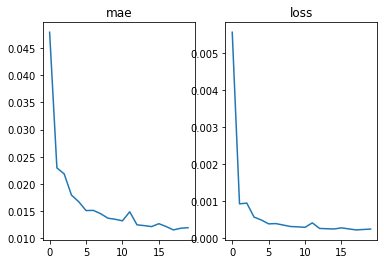

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

hist = history
fig,(ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = False)
ax0.plot(hist.history["mae"], label = 'mae')
ax0.set(title='mae')
ax1.plot(hist.history["loss"], label = 'loss')
ax1.set(title='loss')

In [ ]:
predict_X_Hats = model.predict(np.array(TDOA_images_val))

distance_gap = np.sqrt(np.sum(np.square(predict_X_Hats*25 - np.array(ylabels_val)*25), axis = 1))

mean_distance_gap = np.mean(distance_gap)
print('평균 오차 거리 : ' , np.round(mean_distance_gap,4) , '미터')

평균 오차 거리 :  0.4007 미터


# 결과에 대한 해석..? 간단한 모델과 비교? 논문을 참고해보자